# Topic Clustering

1. Use an embedding model, e.g., bge-en-base-v1.5 to extract embedding vector of each articles.
2. Use t-SNE to visualize the manifold of all articles.

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=','

env: CUDA_VISIBLE_DEVICES=','


In [2]:
import pandas as pd
from FlagEmbedding import FlagModel
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from more_itertools import chunked, flatten

torch.cuda.is_available = lambda: False
torch.cuda.device_count = lambda: 0

In [3]:
df = pd.read_csv("../data/dedup_data.csv")
#df = df.sample(n=50, random_state=42)
articles = df.Content.tolist()

In [4]:
bge = FlagModel("BAAI/bge-base-en-v1.5", use_fp16=True)
bge.model.to("cpu")
bge.device = torch.device("cpu")
"""
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")
bge = AutoModel.from_pretrained("BAAI/bge-base-en-v1.5")
bge.eval()

def encode(sentences: list[str]):
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
 
    with torch.no_grad():
        model_output = bge(**encoded_input)
        # Perform pooling. In this case, cls pooling.
        sentence_embeddings = model_output[0][:, 0]
    # normalize embeddings
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings
"""

'\ntokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")\nbge = AutoModel.from_pretrained("BAAI/bge-base-en-v1.5")\nbge.eval()\n\ndef encode(sentences: list[str]):\n    # Tokenize sentences\n    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors=\'pt\')\n    # Compute token embeddings\n \n    with torch.no_grad():\n        model_output = bge(**encoded_input)\n        # Perform pooling. In this case, cls pooling.\n        sentence_embeddings = model_output[0][:, 0]\n    # normalize embeddings\n    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)\n    return sentence_embeddings\n'

In [5]:
embeddings = bge.encode(articles)
#embeddings = [encode(chunk) for chunk in tqdm(list(chunked(articles, 10)))]

Inference Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:06<00:00, 60.23s/it]


In [6]:
df['bge_embedding'] = embeddings.tolist()

In [7]:
df.to_parquet("../data/emb_output.parquet", engine="pyarrow")

In [8]:
def plot_2d(embeddings, colors, perplexity=5):
   tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)  # Adjust perplexity based on your dataset
   embeddings_2d = tsne.fit_transform(embeddings)
   plt.figure(figsize=(8, 6))
   plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6, edgecolors='w', s=10)
   plt.title('t-SNE Visualization of Document Embeddings')
   plt.grid(True)
   plt.show()

In [9]:
colors = ['blue'] * len(df)

/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/mnt/raid-s3/usr/khoa/dev/TemporalLens/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


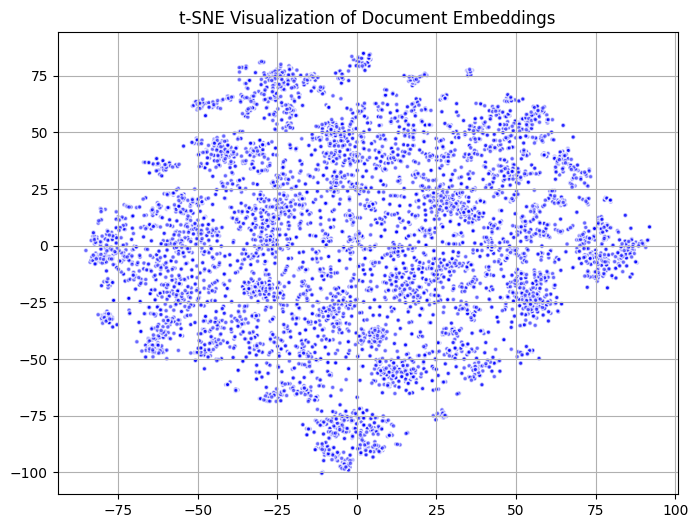

In [10]:
plot_2d(embeddings, colors, perplexity=30)

# Sentence Clustering